# Frequency analysis

$$
\dot T = \kappa \, \nabla^2 T + f
$$


$$
T = \tilde T \, e^{iwt}
$$


$$
iw\, \tilde T - \kappa \, \nabla^2 \tilde T = f
$$

$$
\int iw\, \tilde T \, v\, dx - \kappa  \int \nabla^2 \tilde T v\, dx = \int f v\, dx
$$

$$
 +\kappa \int \nabla \tilde T \nabla v\, dx  - \kappa \int \nabla T v \, ds +  \int iw\, \tilde T \, v\, dx = \int f v\, dx
$$

Longueur de la zone chauffé: $L=1$

In [1]:
import dolfin as df
import matplotlib.pyplot as plt

import mshr

In [309]:
# Geometry and Mesh
domain_size = 7*2

domain = mshr.Rectangle(df.Point(0, 0), df.Point(domain_size, .5))

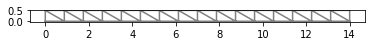

In [328]:
mesh = mshr.generate_mesh(domain, 5)

df.plot(mesh);

## boundary conditions

In [329]:
class SurfaceExt(df.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and\
               df.near(x[0], 0, df.DOLFIN_EPS)

In [330]:
surface_ext = SurfaceExt()

In [331]:
# MeshFunctions marking boundary and cell parts
boundary_markers = df.FacetFunction("size_t", mesh)

In [332]:
boundary_markers.set_all(0)
surface_ext.mark(boundary_markers, 1)

# boundary_markers.array()

In [333]:
ds = df.Measure('ds', domain=mesh, subdomain_data=boundary_markers)

https://fenics.readthedocs.io/projects/dolfin/en/2017.2.0/demos/cahn-hilliard/python/demo_cahn-hilliard.py.html

In [334]:
P1 = df.FiniteElement("Lagrange", mesh.ufl_cell(), 2)
W = df.FunctionSpace(mesh, P1*P1)

In [335]:
(u_r, u_i) = df.TrialFunctions(W)
(v_r, v_i) = df.TestFunctions(W)

grad = df.grad
kappa = 1
w = 2*kappa

a_r = kappa*( df.inner(grad(u_r),grad(v_r))*df.dx - df.inner(grad(u_i),grad(v_i))*df.dx )\
      - w * u_i*v_i*df.dx
a_i = kappa*( df.inner(grad(u_r),grad(v_i))*df.dx + df.inner(grad(u_i),grad(v_r))*df.dx )\
      + w * u_r*v_r*df.dx


a = a_i + a_r

In [350]:
# Define boundary condition

bc_ampl = df.DirichletBC(W.sub(0), df.Constant(1.0), surface_ext)
bc_phase = df.DirichletBC(W.sub(1), df.Constant(0.0), surface_ext)

bcs = [bc_ampl, bc_phase]

In [337]:
# Define input data

f = df.Constant(.0)

L = f*v_r*df.dx + f*v_i*df.dx

In [338]:
# Solve problem
u = df.Function(W)
df.solve(a == L, u, bcs)

In [348]:
u**2

Calling FFC just-in-time (JIT) compiler, this may take some time.


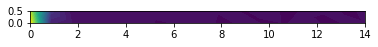

In [346]:
df.plot(u**2)

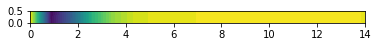

In [340]:
df.plot(u.sub(1))

In [341]:
import numpy as np

In [342]:
x_plot = np.linspace(0, 6, 50)
sol_complex = np.array([u([x, 0]) for x in x_plot])

In [343]:
amplitude = np.sqrt( np.sum(sol_complex**2, axis=1) )
phase = np.arctan2(sol_complex[:, 1], sol_complex[:, 0])

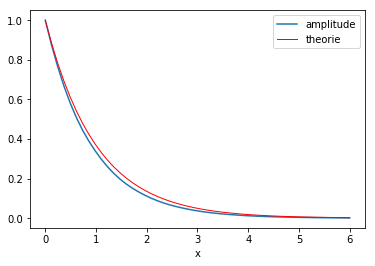

In [344]:
plt.plot(x_plot, amplitude, label="amplitude")
#plt.plot(x_plot, phase, label="phase")
plt.plot(x_plot, np.exp(-x_plot), 'r', linewidth=1, label="theorie")
plt.legend(); plt.xlabel('x');

## Post process

In [ ]:
# Length of the interior boundary:
L_int = df.assemble( df.Constant(1.)*ds(2) )
print(L_int)

In [ ]:
# Flux chaleur moyen vers le sol:
df.assemble( df.Dx(u, 1)*ds(2) )/L_int

In [ ]:
# Flux sortant de domain
n = df.FacetNormal(mesh)
flux_1 = df.assemble(df.dot(df.grad(u), n)*ds(1))
flux_1